In [ ]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #01 - Function Fitting

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using function fitting.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [1]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

In [2]:
### Read in observations ###
anum = np.loadtxt("RAOBs_201903131200.txt",
                 delimiter=",",usecols=(1,2,3))
aplace = np.loadtxt("RAOBs_201903131200.txt",
                 delimiter=",",usecols=0,dtype='str')
anum2 = np.genfromtxt("RAOBs_201903131200.txt", delimiter=",", names=("stn","lat", "lon", "hgts", "dir", "spd"))
#display(anum2)
lat = anum2['lat']
lon = anum2['lon']
height = anum2['hgts']

print(lon)

#print(len(anum[:,0]))

[ -90.2   -66.   -113.9   -73.6   -96.   -105.1   -85.8  -133.4   -68.5
  -58.5   -62.2   -80.6   -78.   -101.1   -94.9   -60.   -111.9   -81.2
  -68.4  -126.8  -122.5   -94.    -60.4  -127.3   -66.2  -122.8  -106.6
  -98.4  -152.4   -79.9  -156.6  -103.2   -72.2  -101.7  -150.   -131.5
  -82.4   -93.6  -161.8  -100.7   -85.2   -86.6  -116.2   -97.4  -156.7
  -78.7   -89.9   -68.   -162.7   -69.96  -80.    -97.5   -99.9  -104.7
 -100.7  -110.8  -104.8  -100.9   -83.4   -90.5  -106.7   -81.7  -147.8
  -84.5  -111.8   -95.6   -96.7  -106.6  -108.5   -88.1   -79.9   -70.26
  -77.4   -83.8   -88.6   -93.3  -155.    -90.    -81.7   -66.    -61.3
 -100.6   -93.2   -92.2  -114.2   -92.2  -102.2   -99.    -79.6  -122.8
  -76.88  -80.2   -93.55 -106.4   -97.2   -81.6  -117.1   -81.6  -118.59
 -122.2   -95.6   -97.6   -72.86 -165.4  -116.4  -162.6   -97.4   -89.6
  -80.2  -103.   -118.2  -108.4   -75.4   -79.5   -84.2   -69.8   -93.3
  -93.8   -89.7  -111.9  -123.   -170.22  -82.4  -110.6   -84.

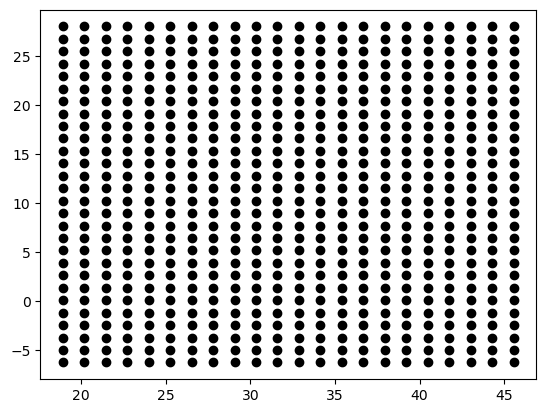

In [3]:
### Set up analysis map with a 22x28 rectangular grid of points ###
x0 = 18.9
y0 = -6.3
xgrid = x0+np.arange(22)*1.27
ygrid = y0+np.arange(28)*1.27 #in southwest corner

x,y = np.meshgrid(xgrid, ygrid, indexing='xy')
#print(alist)

plt.plot(x, y, marker='o', color='k', linestyle='none')

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

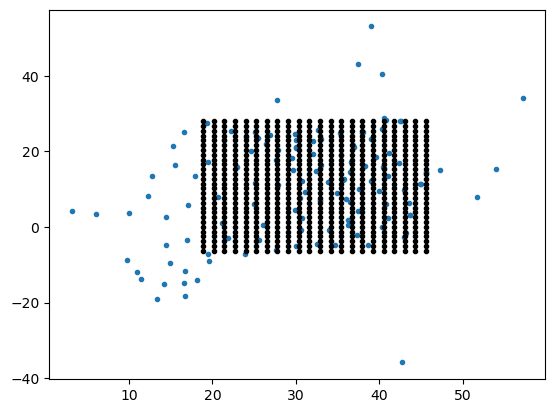

In [4]:
### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)###
'''
Note: to convert between lat/lon, we use the general equation
 y = m*rho*sigma*cos(phi)*sin(lambda0 - lambda), where rho = avg radius of earth (in cm), phi = lat, lambda = lon, lambda0 = 60N (given), m = map conversion factor, and sigma = ((1+sin(phi0))/(1+sin(phi)))
 x = m*rho*sigma*cos(phi)*cos(lambda0 - lambda)
'''
xobs = np.empty(len(lon))
yobs = np.empty(len(lat))
m = 1/15000000
l = -115*np.pi/180
phi0 = 60*np.pi/180
r = 637100000 #centimeters

for n in np.arange(len(anum)):
    xobs[n] = m*r*((1+np.sin(60*np.pi/180))/(1+np.sin(lat[n]*np.pi/180)))*np.cos(lat[n]*np.pi/180)*np.cos((lon[n]*np.pi/180)-l)
    yobs[n] = m*r*((1+np.sin(60*np.pi/180))/(1+np.sin(lat[n]*np.pi/180)))*np.cos(lat[n]*np.pi/180)*np.sin((lon[n]*np.pi/180)-l)


#print()
plt.plot(xobs,yobs,marker='.',linestyle='none')
plt.plot(x, y, marker='.', color='k', linestyle='none')
plt.show

In [13]:
### Perform 500mb geopotential height analyses using a second order 2-d polynomial with two ###
### radii of influence (10cm & 20cm) ###
ROI = [10,20,6]
N_OBS = np.zeros((len(x),len(x[0]),len(ROI)))
ANALYSIS = np.zeros((len(x),len(x[0]),len(ROI)))
'''
Note following code is all Jared's
'''
for n_roi in range(len(ROI)):
    roi = ROI[n_roi]
    #for each analysis point
    for i in range(len(x)):
        for j in range(len(x[i])):
            relx = x[i,j] - xobs
            rely = y[i,j] - yobs
            #determine number of points in ROI
            radius = (relx**2 + rely**2)**0.5
            inds_roi = np.where(radius<roi)[0]
            N_OBS[i,j,n_roi] = len(inds_roi)

            #begin making matrices
            xk = relx[inds_roi]
            yk = rely[inds_roi]
            fo = height[inds_roi]

            #create empty arrays to hold summed matrices
            A = np.zeros((6,6))
            f_vector = np.zeros(6)
            #for each ob within roi
            for k in range(len(xk)):
                tmp1 = np.matrix([1,xk[k],yk[k],xk[k]**2,yk[k]**2,xk[k]*yk[k]])
                tmp2 = tmp1.T * tmp1
                A += np.array(tmp2)
                f_vector += np.array([fo[k],xk[k]*fo[k],yk[k]*fo[k],xk[k]**2 * fo[k],yk[k]**2 * fo[k],xk[k]*yk[k]*fo[k]])
            #divide matrices by number of obs
            A = A/N_OBS[i,j,n_roi]
            f_vector = f_vector/N_OBS[i,j,n_roi]
            #Calculate C Vector
            C = np.linalg.inv(np.matrix(A))*np.matrix(f_vector).T
            ANALYSIS[i,j,n_roi] = C[0,0]


In [22]:
print(ANALYSIS)

[[[5307.80658867 5281.91764473]
  [5345.03976855 5301.67936328]
  [5364.24743333 5332.93567511]
  ...
  [5820.56281212 5835.31460787]
  [5854.20118384 5896.81722301]
  [5994.24453815 5964.4361651 ]]

 [[5309.58307501 5282.27143644]
  [5327.22393849 5306.29632699]
  [5358.32656086 5332.87213014]
  ...
  [5784.53975659 5759.62975478]
  [5817.56441112 5811.5319055 ]
  [5922.87584362 5878.60856007]]

 [[5277.88514459 5275.51738435]
  [5307.02283772 5304.57940801]
  [5327.85078574 5322.53905035]
  ...
  [5705.7263106  5697.79236347]
  [5782.23796033 5745.37428434]
  [5860.83822458 5804.89411974]]

 ...

 [[5444.5908621  5420.34475248]
  [5493.25097145 5462.17198427]
  [5535.81519892 5506.54807825]
  ...
  [5888.19217558 5909.48511312]
  [5870.67548679 5917.30288903]
  [5846.39584292 5922.30412661]]

 [[5462.86338496 5425.27983372]
  [5503.79460657 5479.96966112]
  [5539.73415741 5518.33886259]
  ...
  [5878.97933197 5917.74105087]
  [5875.12676929 5928.38717535]
  [5812.01302645 5927.661850

In [14]:
LAT = (180/np.pi) * (np.pi/2 - 2*np.arctan((((x/m)**2 + (y/m)**2)**0.5)/(r*(1+np.sin(phi0)))))
LON = (180/np.pi) * (l + np.arctan(y/x))

print(LAT[3,3],LON[3,3])

57.840127323059455 -121.25710627701211


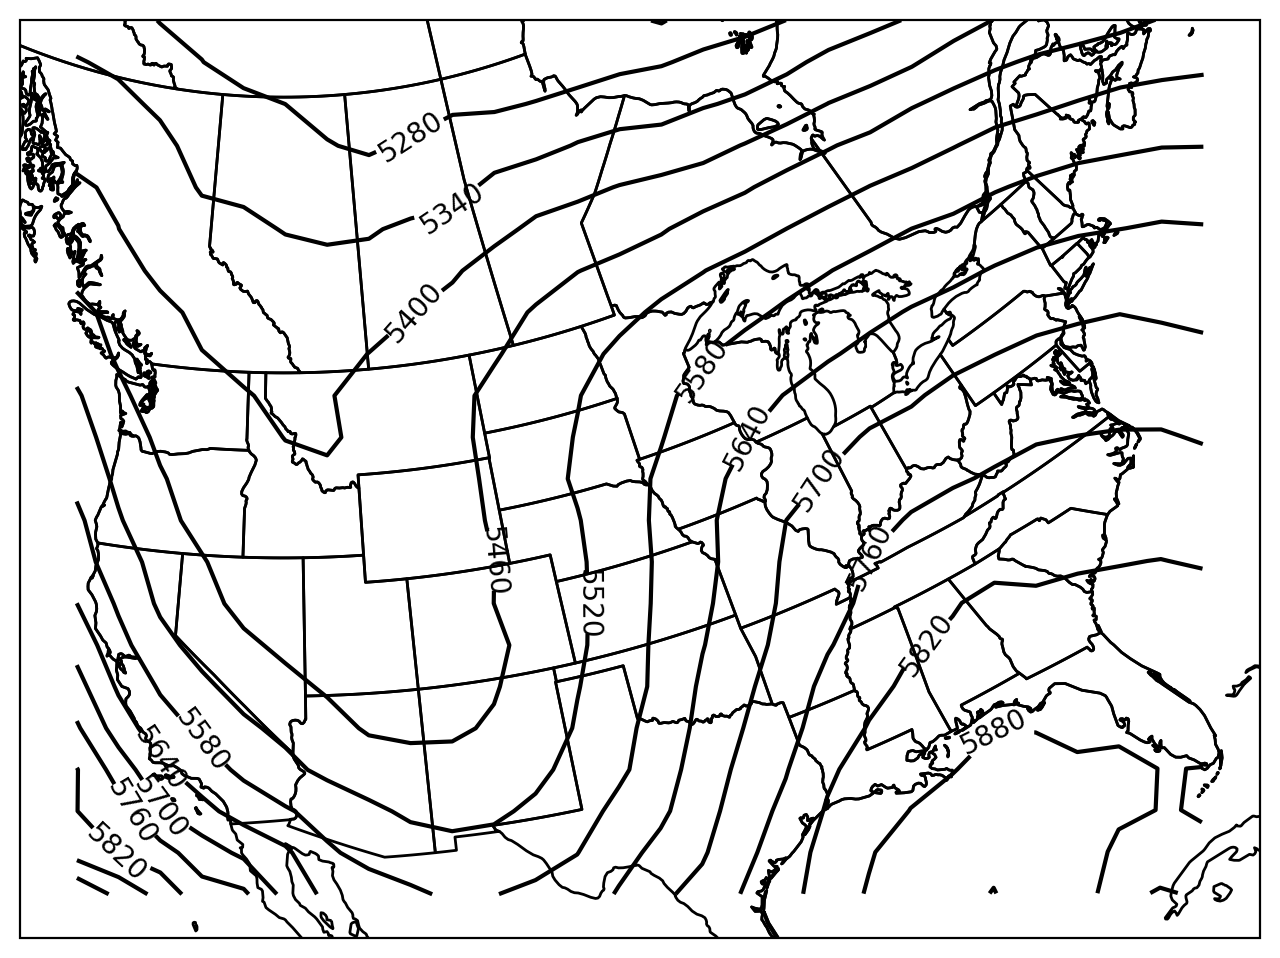

In [15]:
### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(LON,LAT,ANALYSIS[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.show()


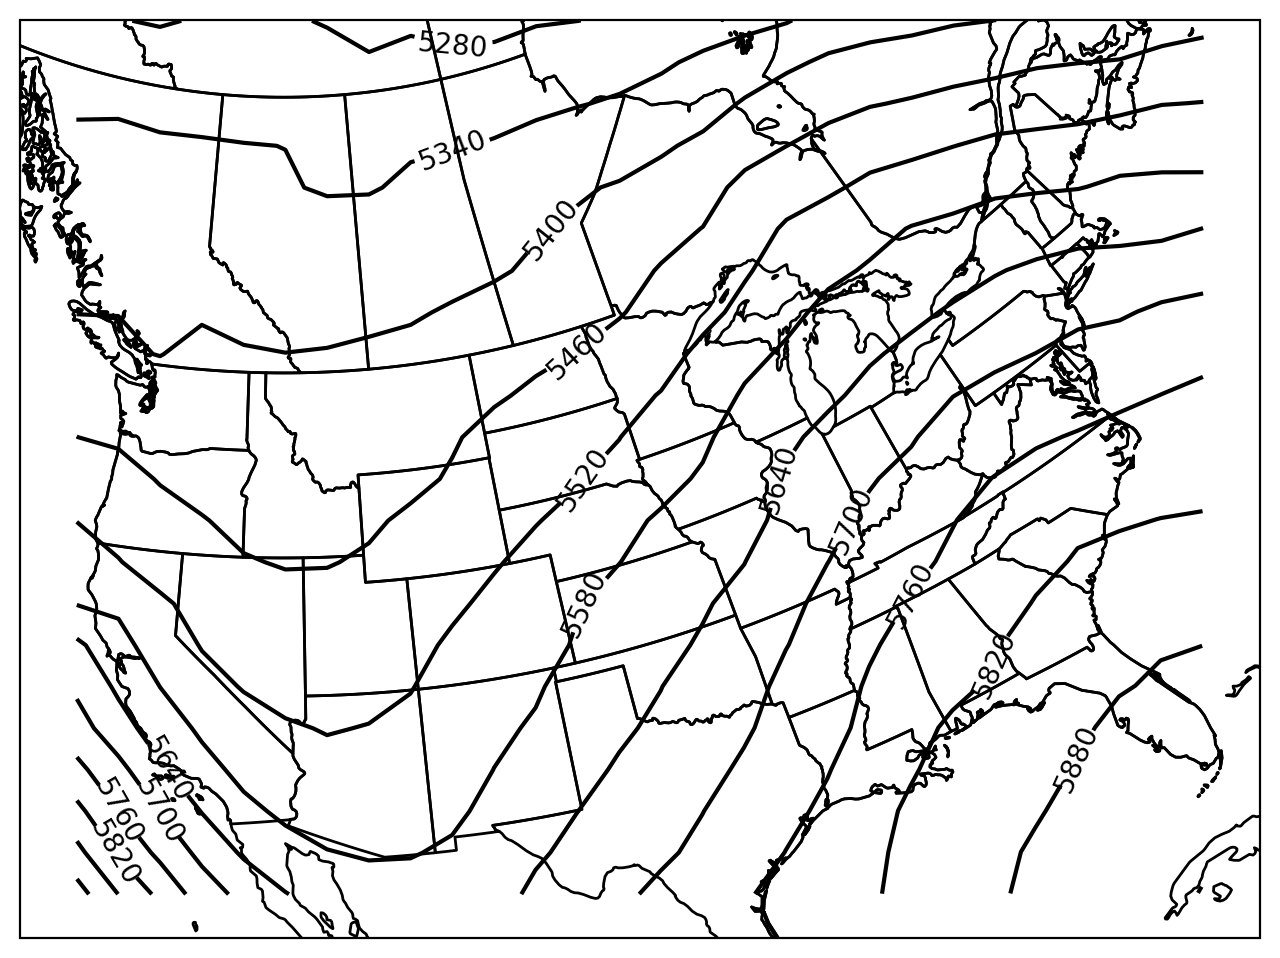

In [16]:
# RoI 20 instead of 10

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(LON,LAT,ANALYSIS[:,:,1],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.show()

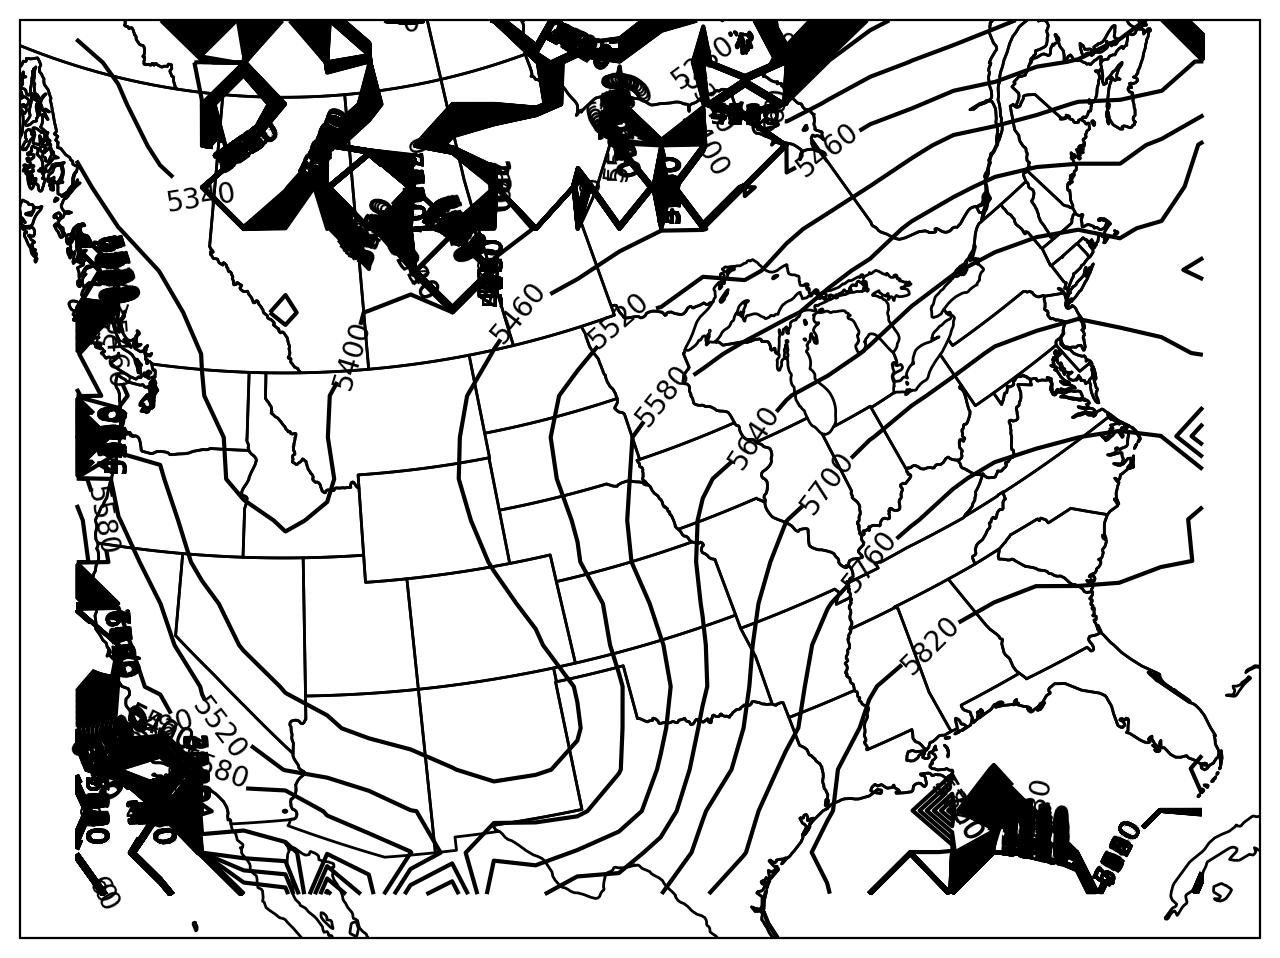

In [17]:
# RoI 6 instead of 10

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(LON,LAT,ANALYSIS[:,:,2],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.show()

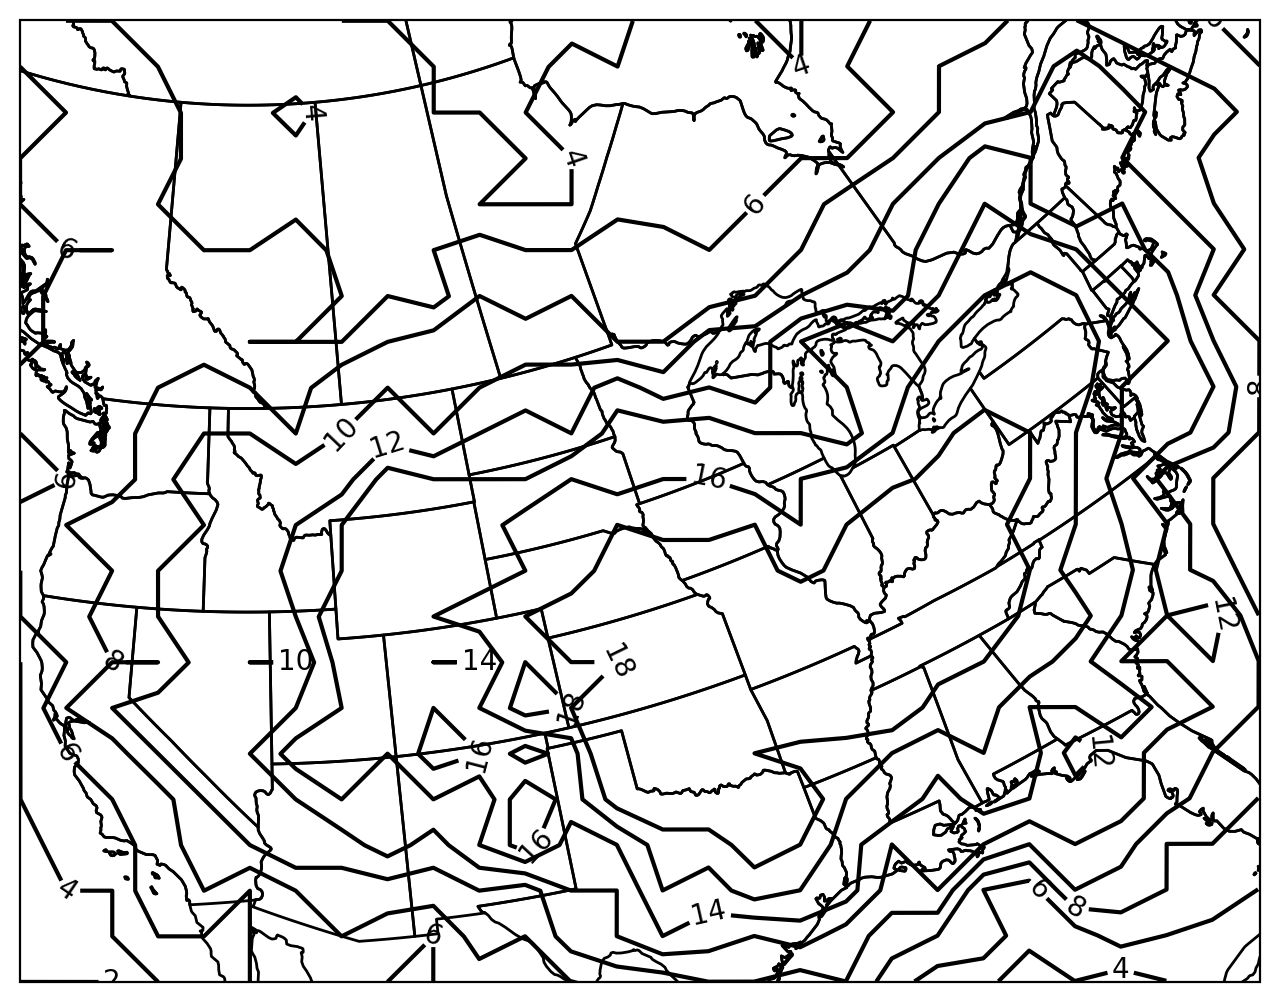

In [21]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(LON,LAT,N_OBS[:,:,2],colors='k',levels=np.arange(0,20,2),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,20,2))

plt.show()

In [ ]:
### Store the analyses in text files ###



In [22]:
### Store the number of observations available for each grid point in text files ###
np.savetxt('RoI-10cm_numObsPerPoint.csv',N_OBS[:,:,0],delimiter=',')
np.savetxt('RoI-20cm_numObsPerPoint.csv',N_OBS[:,:,1],delimiter=',')


### In a separte text file (or below), answer the following questions ###

#1 - Describe the general features that you see in your contoured analyses.#

    General features include: A low pressure system moving into Utah/Colorado and some ridging resultant from that in the Eastern half of the USA.

#2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?#
    
    In the contoured analysis, the smaller radius was able to pick up more details in the placement of the low over the 4 corners area. Similarly, the larger radius smoothed out much of the nuance seen in the smaller radius and showed really only the very largest of waves reliably.

#3 - Run your program using a radius of influence of 6 cm (do not need to show).  
    Describe the results - do they look realistic?  If there are problems, what
    do you think might be causing them?#

    The results for the 6cm RoI are only realistic in the center of the map where there was a fairly dense gathering of observation points. However, on the edges where there are less, particularly over the ocean and Canada where there's basically none, it's having to interpolate from border cases and there's not enough data to properly smooth the edges. So we get a bunch of artifacts along the edges, particularly in the oceans and Canada.

#4 - Suppose you ran this program with a small enough radius of influence that only one
    observation was available for determining a polynomial fit at a grid point.  Should
    you be able to perform the matrix inversion?  Why or why not?#
    
    Yes, you theoretically could perform the matrix inversion, as the size of your matrix doesn't change depending on the variables, at least not in a 2-d, 2nd degree polynomial. It's just that you're averaging 1 point against itself, so the 6x6 matrix isn't one of averages, just of a single point.
